<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [3]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [4]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [5]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [6]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

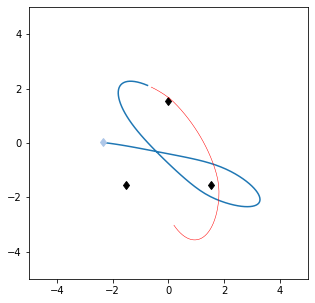

Charges are [-0.52714657 -0.93753794 -0.78466797]


In [7]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

# Task 3.1

## Data Handling and Preprocessing

In [8]:
# Pick the best device
import torch

def try_device(device):
    # Try to put an array on given device. If successful, return device. Else, 'cpu'.
    x = torch.ones((1,))
    try:
        x.to(device)
        return device
    except:
        return 'cpu'

device = try_device('cuda')
if device == 'cpu':
    # mps doesn't support our model (yet?)
    # device = try_device('mps')
    pass


print(f'Device is set to {device}')

Device is set to cpu


In [9]:
# Task 3.1: Using the positions of positively charged particle p1 during a simulation, predict the
# values of negative charges c2, c3, c4
# input = t locations (x, y) of p1 particle, value of t is not fixed

from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_sequence, pad_sequence

class SimulationData(Dataset):
    def __init__(self, sim, charges):
        self.sim = sim
        self.charges = charges

    def __len__(self):
        return len(self.sim)

    def __getitem__(self, idx):
        return self.sim[idx], self.charges[idx]

# Create data loader
def cpu_collate(data):
    # Sort data in order of decreasing sequence length
    data = list(reversed(sorted(data, key=lambda d: len(d[0]))))
    xs = pad_sequence([torch.tensor(x).float() for x, _ in data], batch_first=True)
    ys = torch.stack([torch.tensor(y).float() for _, y in data])
    return xs, ys


# Create data loader
def gpu_collate(data):
    # Sort data in order of decreasing sequence length
    data = list(reversed(sorted(data, key=lambda d: len(d[0]))))
    xs = pad_sequence([torch.tensor(x).float() for x, _ in data], batch_first=True)
    ys = torch.stack([torch.tensor(y).float() for _, y in data])
    return xs.to(device), ys.to(device)


# Batch size needs to evenly divide all train, valid, test sizes (800, 100, 100)
batch_size = 5
cpu_train_dl = DataLoader(SimulationData(simulation_train, charges_train), batch_size=batch_size, shuffle=True, collate_fn=cpu_collate)
cpu_valid_dl = DataLoader(SimulationData(simulation_valid, charges_valid), batch_size=batch_size, shuffle=True, collate_fn=cpu_collate)

gpu_train_dl = DataLoader(SimulationData(simulation_train, charges_train), batch_size=batch_size, shuffle=True, collate_fn=gpu_collate)
gpu_valid_dl = DataLoader(SimulationData(simulation_valid, charges_valid), batch_size=batch_size, shuffle=True, collate_fn=gpu_collate)


In [10]:
print(simulation_train[0].shape)
# Test data loader
xs, ys = next(iter(cpu_train_dl))
print(len(xs))
print(xs[0].shape, ys[0].shape)

(103, 2)
5
torch.Size([110, 2]) torch.Size([3])


In [11]:
# Baseline model: predict the mean value of each charge in the training set
baseline_values = torch.tensor(np.array(charges_train).mean(axis=0))
def baseline_predict(xs):
    batch = xs.shape[0]
    return baseline_values.expand(batch, 3)

loss_fn = lambda y, y_pred: (y - y_pred).abs().sum()

# Baseline error?

def avg_err(model, dl, loss_fn=torch.nn.L1Loss(reduction='sum')):
    loss = 0
    n_samples = 0
    for x, y in dl:
        y_pred = model(x)
        loss += loss_fn(y, y_pred)
        n_samples += x.shape[0]
    return loss / n_samples


print(f'Baseline L1 train error: {avg_err(baseline_predict, cpu_train_dl)}')
print(f'Baseline L1 validation error: {avg_err(baseline_predict, cpu_valid_dl)}')

Baseline L1 train error: 0.7429320812225342
Baseline L1 validation error: 0.7968491911888123


## Model Implementation

In [12]:
class Model_3_1(torch.nn.Module):
    def __init__(self, hidden_dim, n_layers, batch_size):
        super(Model_3_1, self).__init__()
        # input/output size are fixed based on the task description
        input_dim = 2
        output_dim = 3

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.batch_size = batch_size
        
        self.gru = torch.nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True)
        self.relu = torch.nn.ReLU()
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h = self.init_hidden()
        x = x.to(device)
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out
    
    def init_hidden(self):
        # from example of https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
        h0 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim).to(device)
        return h0

xs = xs.to(device)
model_3_1 = Model_3_1(30, 5, batch_size).to(device)
print(model_3_1(xs).shape)

torch.Size([5, 3])


## Model Training

In [13]:
from tqdm import tqdm

train_loss_graph, val_loss_graph = list(), list()

def fit_3_1(model, train_dl, valid_dl, n_epochs):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    loss_func = torch.nn.L1Loss()
    loss_func = loss_func.to(device)

    for i in range(n_epochs):
        print(f'Begin epoch {i + 1}/{n_epochs}')
        for x, y in tqdm(train_dl):
            x = x.to(device)
            y = y.to(device).float()
            y_pred = model(x)
            loss = loss_func(y, y_pred)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        with torch.no_grad():
            train_err = avg_err(model, train_dl)
            val_err = avg_err(model, valid_dl)
            print(f'L1 train error: {train_err}')
            print(f'L1 validation error: {val_err}')
            train_loss_graph.append(train_err)
            val_loss_graph.append(val_err)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

hidden_size = 30
n_layers = 5
model_3_1 = Model_3_1(hidden_size, n_layers, batch_size).to(device)
print(f'Model has {count_parameters(model_3_1)} parameters')
epochs = 1
fit_3_1(model_3_1, gpu_train_dl, gpu_valid_dl, epochs)

Model has 25473 parameters
Begin epoch 1/1


100%|██████████| 160/160 [00:08<00:00, 17.95it/s]


L1 train error: 0.7119362354278564
L1 validation error: 0.7714419364929199


Text(0, 0.5, 'loss value')

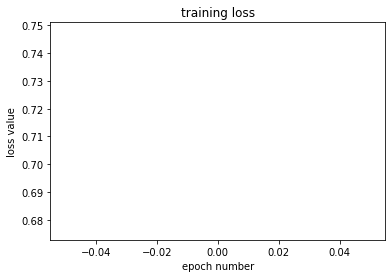

In [15]:
import matplotlib.pyplot as plt

train_loss_graph_cpu = [i.to(device='cpu') for i in train_loss_graph]

plt.plot(train_loss_graph_cpu)
plt.title("training loss")
plt.xlabel("epoch number")
plt.ylabel("loss value")

Text(0, 0.5, 'loss value')

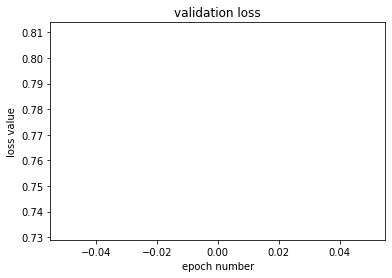

In [16]:
val_loss_graph_cpu = [i.to(device='cpu') for i in val_loss_graph]

plt.plot(val_loss_graph_cpu)
plt.title("validation loss")
plt.xlabel("epoch number")
plt.ylabel("loss value")

## Evaluation

In [17]:
#todo

# Task 3.2

## Data Handling and Preprocessing

In [18]:
#todo

## Model Implementation

In [19]:
x_train_shapes = [np.array(simulation_train_task32, dtype=object)[i].shape[0] for i in range(len(simulation_train_task32))]
y_train_shapes = [np.array(simulation_continued_train, dtype=object)[i].shape[0] for i in range(len(simulation_continued_train))]

In [20]:
print(f"Training x | Mean: {np.array(x_train_shapes).mean()}, Std: {np.array(x_train_shapes).std()}, Min: {np.array(x_train_shapes).min()}, Max: {np.array(x_train_shapes).max()}")
print(f"Training y | Mean: {np.array(y_train_shapes).mean()}, Std: {np.array(y_train_shapes).std()}, Min: {np.array(y_train_shapes).min()}, Max: {np.array(y_train_shapes).max()}")

Training x | Mean: 99.49333333333334, Std: 6.2841034010871875, Min: 90, Max: 110
Training y | Mean: 41.026666666666664, Std: 12.265913020326789, Min: 20, Max: 60


In [21]:
# Task 3.2: Using the positions of positively charged particle p1 during a simulation up to t=10 +- 1,
# continue its trajectory for an additional 4 +- 2 seconds.
# input = t locations (x, y) of p1 particle, value of t is not fixed
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_sequence, pad_sequence


global zero_x
zero_x = torch.zeros((110, 2))
global zero_y
zero_y = torch.zeros((60, 2))


class loadContinued(Dataset):
    def __init__(self, sim, cont_positions):
        self.sim = sim
        self.cont_positions = cont_positions
    
    def __len__(self):
        return len(self.sim)
    
    def __getitem__(self, index):
        return self.sim[index], self.cont_positions[index]

# Create data loader
def gpu_collate(data):
    # Sort data in order of decreasing sequence length
    data = list(reversed(sorted(data, key=lambda d: len(d[0]))))
    
    data_x = [torch.tensor(x).float() for x, _ in data][0]
    xs = pad_sequence([data_x, zero_x])
    xs = xs[:,0,:]
    
    ys = pad_sequence([[torch.tensor(y).float() for _, y in data][0], zero_y])
    ys = ys[:, 0, :]
    
    xs = torch.unsqueeze(xs, 1)
    ys = torch.unsqueeze(ys, 1)
    
    return xs.to(device), ys.to(device)


# No batch size since the length of y differs for each simulation.
gpu_cont_train_dl = DataLoader(loadContinued(simulation_train_task32, simulation_continued_train), shuffle=True, collate_fn=gpu_collate)
gpu_cont_valid_dl = DataLoader(loadContinued(simulation_valid, simulation_continued_valid), shuffle=True, collate_fn=gpu_collate)


In [22]:
from torch import nn

In [23]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, dropout):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.n_layers = n_layers
        
        self.gru = torch.nn.GRU(input_size, hidden_size, n_layers)
        
    def forward(self, x):
        hidden = self.init_hidden()
        output, hidden = self.gru(x, hidden)
        
        return output, hidden
    
    def init_hidden(self):
        h0 = torch.zeros(self.n_layers, self.hidden_size).to(device)
        return h0
        

In [24]:
class Decoder(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers, dropout):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_size, hidden_size, n_layers)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        output, hidden = self.gru(x, hidden)
        output = self.out(output)
        
        return output, hidden
    

In [25]:
from tqdm import tqdm
import random

train_loss_graph, val_loss_graph = list(), list()
criterion = torch.nn.L1Loss()


def fit_seq(encoder_model, decoder_model, train_dl, valid_dl, n_epochs, teacher_forcing_ratio):
    lr = 1e-4
    encoder_optimizer = torch.optim.AdamW(encoder_model.parameters(), lr=lr)
    decoder_optimizer = torch.optim.AdamW(decoder_model.parameters(), lr=lr)
    loss_func = torch.nn.L1Loss()
    loss_func = loss_func.to(device)

    for i in range(epochs):
        print(f'Begin epoch {i + 1}/{n_epochs}')
        train_loss, val_loss = list(), list()
        
        encoder_model = encoder_model.train()
        decoder_model = decoder_model.train()
        for x, y in tqdm(train_dl):
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            
            encoder_output, hidden = encoder_model(x.squeeze(1))
            outputs = torch.zeros(y.shape[0], 2).to(device)
            
            # The initial input to the decoder is the last input position
            input_decoder = x[-1]
            for inx, y_i in enumerate(y):
                output, hidden = decoder_model(input_decoder, hidden)
                
                outputs[inx] = output
                
                teacher_force = random.random() < teacher_forcing_ratio
                input_decoder = y_i if teacher_force else output
            
            y = y.squeeze(1)
            loss = loss_func(outputs, y)
            loss.backward()
            
            encoder_optimizer.step()
            decoder_optimizer.step()
            
            train_loss.append(loss.item())            
            torch.cuda.empty_cache()
        
        train_loss_graph.append(sum(train_loss) / len(train_dl))
        
        encoder_model = encoder_model.eval()
        decoder_model = decoder_model.eval()
        with torch.no_grad():
            for x_val, y_val in valid_dl:
                encoder_output, hidden = encoder_model(x_val.squeeze(1))
                outputs_val = torch.zeros(y_val.shape[0], 2).to(device)
                
                input_decoder = x_val[-1]
                for inx, y_i in enumerate(y_val):
                    output, hidden = decoder_model(input_decoder, hidden)
                    
                    outputs_val[inx] = output
                    
                    input_decoder = output
                
                y_val = y_val.squeeze(1)
                loss_val = loss_func(outputs_val, y_val)
                
                val_loss.append(loss_val.item())
                torch.cuda.empty_cache()
            
        val_loss_graph.append(sum(val_loss) / len(valid_dl))
        
        print(f'Average loss: {round(train_loss_graph[-1],5)}')
        print(f'val loss: {round(val_loss_graph[-1],5)}')
    


In [26]:
n_layers = 1
dropout = 0.5
input_size = 2
output_size = 2
hidden_size = 256

encoder_model = Encoder(input_size, hidden_size, n_layers, dropout).to(device)
decoder_model = Decoder(input_size, output_size, hidden_size, n_layers, dropout).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Encoder Model has {count_parameters(encoder_model)} parameters')
print(f'Decoder Model has {count_parameters(decoder_model)} parameters')
epochs = 30
fit_seq(encoder_model=encoder_model,
        decoder_model=decoder_model,
        train_dl=gpu_cont_train_dl, 
        valid_dl=gpu_cont_valid_dl, 
        n_epochs=epochs, 
        teacher_forcing_ratio=0.5)
encoder_model = encoder_model.eval()
decoder_model = decoder_model.eval()

Encoder Model has 199680 parameters
Decoder Model has 200194 parameters
Begin epoch 1/30


100%|██████████| 150/150 [00:07<00:00, 19.50it/s]


Average loss: 0.87601
val loss: 1.06966
Begin epoch 2/30


100%|██████████| 150/150 [00:07<00:00, 21.09it/s]


Average loss: 0.57227
val loss: 1.01828
Begin epoch 3/30


100%|██████████| 150/150 [00:07<00:00, 20.93it/s]


Average loss: 0.38905
val loss: 1.53805
Begin epoch 4/30


100%|██████████| 150/150 [00:07<00:00, 21.06it/s]


Average loss: 0.32217
val loss: 0.99942
Begin epoch 5/30


100%|██████████| 150/150 [00:07<00:00, 21.37it/s]


Average loss: 0.29472
val loss: 1.22082
Begin epoch 6/30


100%|██████████| 150/150 [00:07<00:00, 20.58it/s]


Average loss: 0.26694
val loss: 1.63606
Begin epoch 7/30


100%|██████████| 150/150 [00:07<00:00, 20.11it/s]


Average loss: 0.262
val loss: 1.07398
Begin epoch 8/30


100%|██████████| 150/150 [00:07<00:00, 20.93it/s]


Average loss: 0.25672
val loss: 1.0606
Begin epoch 9/30


100%|██████████| 150/150 [00:07<00:00, 20.12it/s]


Average loss: 0.24446
val loss: 1.44592
Begin epoch 10/30


100%|██████████| 150/150 [00:07<00:00, 21.08it/s]


Average loss: 0.2366
val loss: 1.33565
Begin epoch 11/30


100%|██████████| 150/150 [00:07<00:00, 20.77it/s]


Average loss: 0.22828
val loss: 1.156
Begin epoch 12/30


100%|██████████| 150/150 [00:07<00:00, 21.43it/s]


Average loss: 0.22109
val loss: 1.12094
Begin epoch 13/30


100%|██████████| 150/150 [00:07<00:00, 20.92it/s]


Average loss: 0.21642
val loss: 1.36959
Begin epoch 14/30


100%|██████████| 150/150 [00:07<00:00, 21.31it/s]


Average loss: 0.21256
val loss: 1.5458
Begin epoch 15/30


100%|██████████| 150/150 [00:07<00:00, 19.19it/s]


Average loss: 0.2042
val loss: 1.36351
Begin epoch 16/30


100%|██████████| 150/150 [00:08<00:00, 17.30it/s]


Average loss: 0.1962
val loss: 1.45221
Begin epoch 17/30


100%|██████████| 150/150 [00:07<00:00, 20.69it/s]


Average loss: 0.19863
val loss: 1.39081
Begin epoch 18/30


100%|██████████| 150/150 [00:06<00:00, 21.46it/s]


Average loss: 0.19656
val loss: 1.20785
Begin epoch 19/30


100%|██████████| 150/150 [00:07<00:00, 21.09it/s]


Average loss: 0.18206
val loss: 1.37072
Begin epoch 20/30


100%|██████████| 150/150 [00:06<00:00, 21.53it/s]


Average loss: 0.18134
val loss: 1.18346
Begin epoch 21/30


100%|██████████| 150/150 [00:07<00:00, 21.35it/s]


Average loss: 0.18502
val loss: 1.02341
Begin epoch 22/30


100%|██████████| 150/150 [00:06<00:00, 21.45it/s]


Average loss: 0.19096
val loss: 1.60231
Begin epoch 23/30


100%|██████████| 150/150 [00:07<00:00, 21.39it/s]


Average loss: 0.17506
val loss: 1.13273
Begin epoch 24/30


100%|██████████| 150/150 [00:07<00:00, 21.33it/s]


Average loss: 0.16848
val loss: 1.5037
Begin epoch 25/30


100%|██████████| 150/150 [00:07<00:00, 20.81it/s]


Average loss: 0.16974
val loss: 1.32684
Begin epoch 26/30


100%|██████████| 150/150 [00:07<00:00, 20.71it/s]


Average loss: 0.16067
val loss: 1.5397
Begin epoch 27/30


100%|██████████| 150/150 [00:07<00:00, 20.57it/s]


Average loss: 0.16402
val loss: 1.32265
Begin epoch 28/30


100%|██████████| 150/150 [00:07<00:00, 21.24it/s]


Average loss: 0.1653
val loss: 1.1635
Begin epoch 29/30


100%|██████████| 150/150 [00:07<00:00, 21.29it/s]


Average loss: 0.15924
val loss: 1.17294
Begin epoch 30/30


100%|██████████| 150/150 [00:07<00:00, 21.19it/s]


Average loss: 0.16678
val loss: 1.4549


(110, 2) torch.Size([60, 1, 2]) torch.Size([60, 2])
loss value: 1.1463611125946045


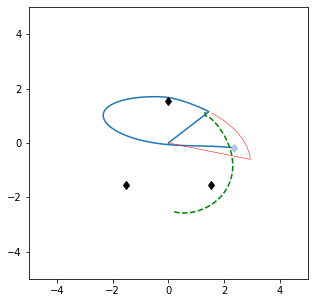

In [65]:
x, y = next(iter(gpu_cont_train_dl))

encoder_output, hidden = encoder_model(x.squeeze(1))
outputs = torch.zeros(y.shape[0], 2).to(device)

input_decoder = x[-1]
for inx, y_i in enumerate(y):
    output, hidden = decoder_model(input_decoder, hidden)

    outputs[inx] = output

    input_decoder = output

x = x.squeeze(1)
x = x.to(device='cpu').detach().numpy()
new_y_pred = outputs.to(device='cpu').detach().numpy()
    
print(x.shape, y.shape, outputs.shape)
print(f'loss value: {criterion(y.squeeze(1), outputs).item()}')
plot_example(x, x_gt=y.squeeze(1), x_pred=np.array(new_y_pred))